In [1]:
import numpy as np
import sys
sys.path.append('..')
from utils.np_utils.pose_evaluation_utils import *
from utils.np_utils.pose_helper import *
from utils.np_utils.helper import *
import pandas as pd

from utils.np_utils.pose_helper import make_intrinsic, Traj_helper
from utils.np_utils.viz_helper import *


#updated version from pose_evaluation_utils
def find_ate(gts,preds):

    gt, pred = gts[:,:3,-1],preds[:,:3,-1]

    offset = gt[0] - pred[0]

    pred += offset[None,:]

    # Optimize the scaling factor
    scale = np.sum(gt * pred)/np.sum(pred ** 2)
    pred = pred*scale
    alignment_error = pred - gt

    #average translation error
    rmse = np.sqrt(np.sum(alignment_error ** 2))/len(gt)

    preds[:,:3,-1] = pred
    return preds,rmse

def compute_error(gt_path,pred_path):
    gts = txt_to_4x4(gt_path)
    gts = align_to_origin(gts)
    preds = txt_to_4x4(pred_path)
    preds = align_to_origin(preds,True)

    preds_scaled,ate = find_ate(gts,preds)
    rpe = find_all_rpe(gts,preds_scaled)

    print(ate,rpe)
    return preds, preds_scaled

def compute_error_TUM(gt_path,pred_path):
    gts = txt_to_4x4(gt_path)
    gts = align_to_origin(gts)
    preds = txt_to_4x4(pred_path)
    
    p, trans_err = align(np.matrix(preds[:,:3,3].T),np.matrix(gts[:,:3,3].T))
    pred_scaled = np.copy(preds)
    pred_scaled[:,:3,3] = p.T
    print("TransErr = ", np.sqrt(np.dot(trans_err,trans_err) / len(trans_err)))

    _,ate = find_ate(gts,pred_scaled)
    rpe = find_all_rpe(gts,pred_scaled)

    print(ate,rpe)
    return preds, pred_scaled


In [2]:

import glob
from utils.np_utils.helper import txt_to_q
import tqdm

All_data = {}
for env in sorted(glob.glob('../data/Trajs/*')):
    temp = []
    for fnames in sorted(glob.glob(env+'/P*.txt')):
        if len(temp)==0:
            temp=txt_to_q(fnames)
        else:
            temp = np.concatenate((temp,txt_to_q(fnames)))
    All_data[env.split('/')[-1]] = np.array(temp)
    

# https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line
import matplotlib.pyplot as plt
def order_points(points, ind):
    idxs = [i for i in range(len(points))]
    updated_id = [idxs.pop(ind)]
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)

    i_xyz = np.array([3,7,11,15])
    while len(points)>0:
        d      = np.linalg.norm(np.array(points)[:,i_xyz] - np.array(pcurr)[i_xyz], axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        
        if abs(d[ind])>2:
            return points_new, updated_id
            
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        updated_id.append(idxs.pop(ind))
        pcurr  = points_new[-1]               # update the current point
    return points_new, updated_id
# create sine curve:
# x      = np.linspace(0, 2 * np.pi, 100)
# y      = np.sin(x)
# xs = data[:,0]#np.linspace(0, 2 * np.pi, 1000)
# ys = data[:,1]#np.sin(x)
# zs = data[:,2]

data = np.concatenate((All_data['abandonedfactory'],All_data['abandonedfactory_night']))
# x,y,z,q1,q2,q3,q4 = data.T

# # shuffle the order of the x and y coordinates:
# idx    = np.random.permutation(x.size)
# xs,ys,zs  = x[idx], y[idx],   # shuffled points

d1 = np.copy(data)
idx = np.random.permutation(len(data))
data = [pose_vec_q_to_mat(i) for i in data[idx]]

# find the least point:
maax = -1000000
for i in range(len(data)):
    if np.linalg.norm(data[i])>maax:
        ind = i
        maax = np.linalg.norm(data[i])
#data.argmin()

# assemble the x and y coordinates into a list of (x,y) tuples:
points = list(data)#[(xx,yy,zz)  for xx,yy,zz in zip(x,y,z)]
# points = list(np.array(points).reshape((len(points),16)))


In [3]:
mat = np.zeros((len(points),len(points)))
for i in tqdm.tqdm(range(len(points))):
    for j in range(i+1,len(points)):
        t = np.linalg.norm(inv(points[i])@(points[j])-np.eye(4))
        mat[i,j] = t
        mat[j,i] = t
        # mat[-1].append(np.linalg.norm(inv(i)@(j)-np.eye(4)))
np.save('mat.npy',mat)
np.save('points.npy',points)

  0%|          | 0/19875 [00:00<?, ?it/s]

100%|██████████| 19875/19875 [41:45<00:00,  7.93it/s] 


In [4]:
import numpy as np
import networkx as nx
import itertools
mat = np.load('mat.npy')
points = np.load('points.npy')
mat = mat[:10000,:10000]
# mat[mat>5]=-1
# Replace this with your actual distance matrix
distances = np.array(mat)


Total distance: 5010.7905086567225


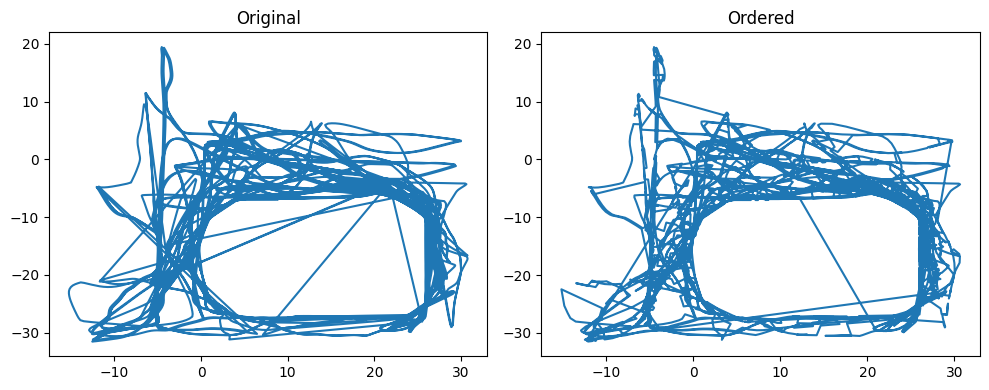

In [5]:

# Create a complete graph using the distances matrix
G = nx.Graph()
n = distances.shape[0]  # Number of nodes

for i in range(n):
    for j in range(i+1, n):
        if distances[i][j]==-1:
            continue
        G.add_edge(i, j, weight=distances[i][j])

# Use the asadpour_atsp algorithm from the networkx's approximation module
shortest_tour = nx.approximation.greedy_tsp(G)


# # Find the optimal TSP tour using the Held-Karp algorithm
# shortest_tour = nx.algorithms.approximation.asadpour_atsp(G, source=0)

# Calculate the total distance of the tour
total_distance = sum(distances[shortest_tour[i]][shortest_tour[i+1]] for i in range(len(shortest_tour) - 1))

# print("Optimal TSP tour:", shortest_tour)
print("Total distance:", total_distance)


# order the points based on the known first point:
iid = shortest_tour
points_new  = np.array(points)[iid]

# plot:
fig,ax = plt.subplots(1, 2, figsize=(10,4))
data  = np.array(points_new)
ax[0].plot(d1[:,0], d1[:,1])  # original (shuffled) points
ax[1].plot(data[:,0,3], data[:,1,3])  # new (ordered) points
# ax[2].plot([i for i in range(500)], iid[:500])  # original (shuffled) points
ax[0].set_title('Original')
ax[1].set_title('Ordered')
plt.tight_layout()
plt.show()


In [ ]:


window = viewer()

window.init()

count = 1

[window.update_pose_data_live(i, np.random.random(3)) for i in data]

window.run()

IndexError: index 7 is out of bounds for axis 1 with size 4

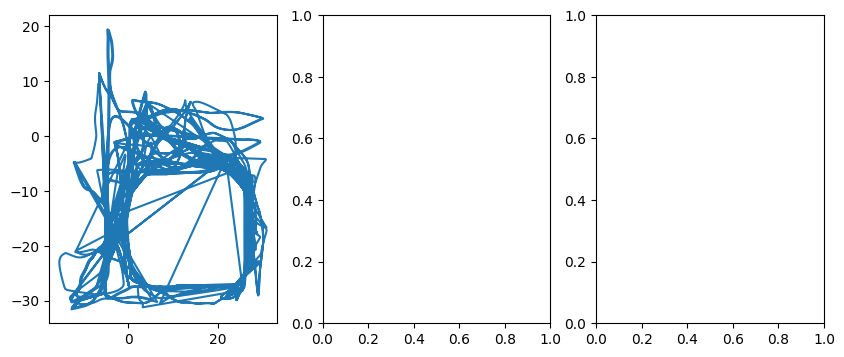

In [6]:

# order the points based on the known first point:
# points_new, iid = order_points(points, ind)

# plot:
fig,ax = plt.subplots(1, 3, figsize=(10,4))
data  = np.array(points_new)
ax[0].plot(d1[:,0], d1[:,1])  # original (shuffled) points
ax[1].plot(data[:,3], data[:,7])  # new (ordered) points
ax[2].plot([i for i in range(500)], iid[:500])  # original (shuffled) points
ax[0].set_title('Original')
ax[1].set_title('Ordered')
plt.tight_layout()
plt.show()
print(iid)

data = data.reshape((len(data),4,4))

udata = np.array([pose_mat_to_vec_q(i) for i in data]) #np.array([xn,yn,zn,q1n,q2n,q3n,q4n])


In [ ]:

window = viewer()

window.init()

count = 1

[window.update_pose_data_live(i, np.random.random(3)) for i in data]

window.run()